<a href="https://colab.research.google.com/github/Yustira/crowd-counting/blob/master/Crowd%20Counting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bangkit Final Project
## Crowd Counting

This notebook contains step-by-step process in building and evaluating model for crowd counting.
<br/>

By:
*   Harrianto Sunaryan
*   Iyas Yustira
*   Muhammad Farrel M
*   Rinda Nur Hafizha



## Load the imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(1)

import scipy
from scipy import spatial
from scipy import ndimage

import tensorflow as tf
import keras
from keras.layers import Conv2D, Average, MaxPooling2D, Flatten,concatenate, Input, Dense, UpSampling2D, Conv2DTranspose, ReLU, Activation, BatchNormalization,Lambda
from keras.models import Model
from keras.losses import mean_squared_error
from keras.losses import mean_absolute_percentage_error
from keras.optimizers import Adam, Nadam
from keras.applications import vgg16
import keras.backend as K

## Load Dataset
In this part, we load the dataset, ground truth, density map, and labels.\
The original dataset can be found in https://personal.ie.cuhk.edu.hk/~ccloy/downloads_mall_dataset.html \
The density maps was generated with Geometry-adaptive kernel. We can generate it from images in mall dataset on this [notebook](https://github.com/Yustira/crowd-counting/blob/master/Generate_density.ipynb) \
The images dataset are normalized into the interval [0,1]

### Run this code only when you are using Colab
This code will download dataset needed to colab's temporary storage

#### Install PyDrive

In [ ]:
!pip install PyDrive

#### Google Drive Authentication

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#### Download the file from the link

##### Download images file in `.npy` format from this [link](https://drive.google.com/file/d/1y0BoU7RIisMgj4PsCPbY02PPm4CEXaEF/view)

In [ ]:
IMAGE_FILE_ID = "1y0BoU7RIisMgj4PsCPbY02PPm4CEXaEF"
downloaded = drive.CreateFile({'id':IMAGE_FILE_ID})
downloaded.GetContentFile('images.npy')        

##### Download ground truth file for images in the dataset from this [link](https://drive.google.com/file/d/1F8MSiZ974Hta6gZcex9DFvGwbhA2u3s8/view)

In [ ]:
IMAGE_GT_FILE_ID = "1F8MSiZ974Hta6gZcex9DFvGwbhA2u3s8"
downloaded = drive.CreateFile({'id':IMAGE_GT_FILE_ID})
downloaded.GetContentFile('images_gt.npy') 

##### Download density map file that has been generated for images in the dataset from this [link](https://drive.google.com/file/d/1-1JXmD6sumzJcATFQzm9Yq7CCDZ2K7cT/view)

In [ ]:
IMAGE_DENSITY_FILE_ID = "1-1JXmD6sumzJcATFQzm9Yq7CCDZ2K7cT"
downloaded = drive.CreateFile({'id':IMAGE_DENSITY_FILE_ID})
downloaded.GetContentFile('images_density.npy') 

##### Download labels for images in the dataset from this [link](https://drive.google.com/file/d/1NYHK2AcLmm-sHpZWFR5vn_ejxX3KB7Mz/view)

In [ ]:
LABEL_FILE_ID = "1NYHK2AcLmm-sHpZWFR5vn_ejxX3KB7Mz"
downloaded = drive.CreateFile({'id':LABEL_FILE_ID})
downloaded.GetContentFile('labels.npy')

### Load dataset from file

In [ ]:
images=np.load('images.npy')
images_gt=np.load('images_gt.npy',allow_pickle=True)
images_density=np.load('images_density.npy')
labels=np.load('labels.npy')

## Data Preview

### Images

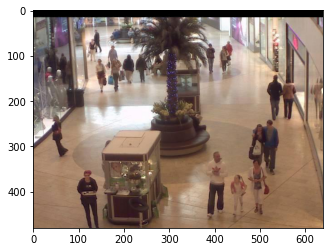

In [ ]:
img=plt.imshow(images[200])

### Images + Ground Truth (Annotated Frame)

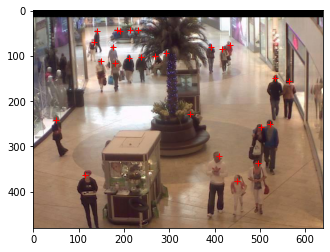

In [ ]:
img=plt.imshow(images[200])
img=plt.plot(images_gt[200][:,0],images_gt[200][:,1],'r+')

### Images + Density Map

number of people: 26.00


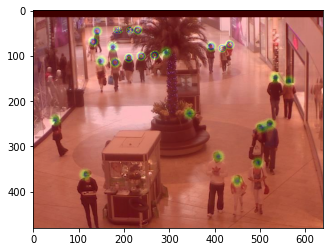

In [ ]:
plt.imshow(images[200])
plt.imshow(images_density[200],cmap='prism',interpolation='bicubic',alpha=0.25)
print('number of people: %4.2f' %np.sum(images_density[200]/1000))

## Create Model

### Import VGG16 as Baseline
Set the input shape for our model\
Creating baseline model with VGG16

In [ ]:
# image size per image patch
size=(96,128)
input_shape=(size[0],size[1],3)
baseline_vgg=vgg16.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

### Main Model Architecture

In [ ]:
def Crowd_CNN(input_shape=input_shape):
    
    input_flow=Input(input_shape)
    base_filter=8
    
    x_vgg=baseline_vgg.get_layer(index=1)(input_flow)
    for i in range(2,10):
        x_vgg=baseline_vgg.get_layer(index=i)(x_vgg)
        
    
    
    x_1=Conv2D(base_filter*16,9,padding='same',activation='relu')(x_vgg)
    x_1=BatchNormalization()(x_1)
    x_1=Conv2D(base_filter*8,7,padding='same',activation='relu')(x_1)
    x_1=BatchNormalization()(x_1)
    x_1=Conv2D(base_filter*4,5,padding='same',activation='relu')(x_1)
    x_1=BatchNormalization()(x_1)
    x_1=Conv2D(1,1,padding='same',activation='relu')(x_1)
    x_1=BatchNormalization()(x_1)
    
    
    x_2=Conv2D(base_filter*8,7,padding='same',activation='relu')(x_vgg)
    x_2=BatchNormalization()(x_2)
    x_2=Conv2D(base_filter*4,5,padding='same',activation='relu')(x_2)
    x_2=BatchNormalization()(x_2)
    x_2=Conv2D(base_filter*2,3,padding='same',activation='relu')(x_2)
    x_2=BatchNormalization()(x_2)
    x_2=Conv2D(1,1,padding='same',activation='relu')(x_2)
    x_2=BatchNormalization()(x_2)
    
    
    x_3=Conv2D(base_filter*4,5,padding='same',activation='relu')(x_vgg)
    x_3=BatchNormalization()(x_3)
    x_3=Conv2D(base_filter*2,3,padding='same',activation='relu')(x_3)
    x_3=BatchNormalization()(x_3)
    x_3=Conv2D(base_filter*1,1,padding='same',activation='relu')(x_3)
    x_3=BatchNormalization()(x_3)
    x_3=Conv2D(1,1,padding='same',activation='relu')(x_3)
    x_3=BatchNormalization()(x_3)
    
    x_4=Conv2D(base_filter*4,3,padding='same',activation='relu')(x_vgg)
    x_4=BatchNormalization()(x_4)
    x_4=Conv2D(base_filter*2,1,padding='same',activation='relu')(x_4)
    x_4=BatchNormalization()(x_4)
    x_4=Conv2D(base_filter*1,1,padding='same',activation='relu')(x_4)
    x_4=BatchNormalization()(x_4)
    x_4=Conv2D(1,1,padding='same',activation='relu')(x_4)
    x_4=BatchNormalization()(x_4)
    
    
    x_conct=concatenate([x_1,x_2,x_3,x_4])
    x_fel=Flatten()(x_conct)
    x_fel=Dense(base_filter*8,activation='relu')(x_fel)
    x_fel=Dense(4,activation='softmax')(x_fel)
    
    x=Lambda(lambda x: x*(1+x_fel))(x_conct)

    
    x=Conv2D(base_filter*2,5,padding='same',activation='relu')(x)
    x=BatchNormalization()(x)
    x=concatenate([x,x_conct])
    x=Conv2D(base_filter*2,3,padding='same',activation='relu')(x)
    x=BatchNormalization()(x)
    x=Conv2DTranspose(base_filter*2, kernel_size=(2, 2), strides=(2, 2))(x)
    x=BatchNormalization()(x)
    x=Conv2D(base_filter*2,3,padding='same',activation='relu')(x)
    x=BatchNormalization()(x)
    x=Conv2DTranspose(base_filter, kernel_size=(2, 2), strides=(2, 2))(x)
    x=BatchNormalization()(x)
    x=Conv2D(base_filter,1,padding='same',activation='relu')(x)
    x=BatchNormalization()(x)
    x=Conv2D(1,1,padding='same',activation='relu')(x)
    
    model=Model(inputs=input_flow,outputs=x)    
    
    return model
    
    
    
    
    
    
    


### SSIM and Euclidean Loss + Custom MAE metrics

In [ ]:
def ssim_loss(y_true, y_pred, c1=0.01**2, c2=0.03**2):
    weights_initial = np.multiply(
        cv2.getGaussianKernel(12, 1.5),
        cv2.getGaussianKernel(16, 1.5).T
    )
    weights_initial = weights_initial.reshape(*weights_initial.shape, 1, 1)
    weights_initial = K.cast(weights_initial, tf.float32)

    mu_F = tf.nn.conv2d(y_pred, weights_initial, [1, 1, 1, 1], padding='SAME')
    mu_Y = tf.nn.conv2d(y_true, weights_initial, [1, 1, 1, 1], padding='SAME')
    mu_F_mu_Y = tf.multiply(mu_F, mu_Y)
    mu_F_squared = tf.multiply(mu_F, mu_F)
    mu_Y_squared = tf.multiply(mu_Y, mu_Y)

    sigma_F_squared = tf.nn.conv2d(tf.multiply(y_pred, y_pred), weights_initial, [1, 1, 1, 1], padding='SAME') - mu_F_squared
    sigma_Y_squared = tf.nn.conv2d(tf.multiply(y_true, y_true), weights_initial, [1, 1, 1, 1], padding='SAME') - mu_Y_squared
    sigma_F_Y = tf.nn.conv2d(tf.multiply(y_pred, y_true), weights_initial, [1, 1, 1, 1], padding='SAME') - mu_F_mu_Y

    ssim = ((2 * mu_F_mu_Y + c1) * (2 * sigma_F_Y + c2)) / ((mu_F_squared + mu_Y_squared + c1) * (sigma_F_squared + sigma_Y_squared + c2))

    return 1 - tf.reduce_mean(ssim, axis=[1, 2, 3])


def ssim_eucli_loss(y_true, y_pred, alpha=0.0025):
    ssim = ssim_loss(y_true, y_pred)
    eucli = mean_squared_error(y_true, y_pred)
    loss = eucli + alpha * ssim
    return loss

def mae_cnt(labels,preds):
    cnt_label=K.sum(labels)
    cnt_pred=K.sum(preds)
    return K.abs(cnt_label-cnt_pred)

### Define the Model

In [ ]:
lr=1e-5
model=Crowd_CNN()
# model.load_weights("Crowd-CNN")
Optimizer=Nadam(lr)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 96, 128, 3)   0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 96, 128, 64)  1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 96, 128, 64)  36928       block1_conv1[1][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 48, 64, 64)   0           block1_conv2[1][0]               
____________________________________________________________________________________________

## Data Pre-Processing

### Normalize images value
Divide them by 255 so it will have value with range [0,1]

In [ ]:
images = images/255

### Create Train and Validation Set
The dataset is divided into training and validation set with 85% : 15% ratio \
X (input) is images and Y (label) is its corresponding density map

In [ ]:
X_train, X_val, Y_train, Y_val=train_test_split(images,images_density,test_size=0.15,random_state=70)

### Add dimension for label

In [ ]:
Y_train=np.expand_dims(Y_train,-1)
Y_val=np.expand_dims(Y_val,-1)

### Function to generate patches of images

Function `get_patch` will generate patches of image from a single full image that will be used for training and evaluation process


In [ ]:
def get_patch(X,Y):
    x_patch=np.zeros([3*X.shape[0],size[0],size[1],3])
    y_patch=np.zeros([3*Y.shape[0],size[0],size[1],1])
    
    for i in range(X.shape[0]):
        for j in range(3):
    
            x1=np.random.randint(0,X.shape[1]-size[0]-1)
            y1=np.random.randint(0,X.shape[2]-size[1]-1)
            x2=size[0]+x1
            y2=size[1]+y1

            x_patch[3*i+j]=X[i,x1:x2,y1:y2,:]
            y_patch[3*i+j]=Y[i,x1:x2,y1:y2,:]
    
    return x_patch,y_patch

## Training
The training process is done with 2 epochs without train the VGG16 layers and 2 epoch with trainable VGG16 layers

### Training with 2 epochs without training the VGG16 layers

In [ ]:
for i in model.layers[:10]:
    i.trainable=False
model.compile(optimizer=Optimizer,loss=ssim_eucli_loss,metrics=[mae_cnt])

In [ ]:
for i in range(2):
    x_patch,y_patch=get_patch(X_train,Y_train)
    x_patch_val,y_patch_val=get_patch(X_val,Y_val)
    
    model.fit(x_patch,y_patch,batch_size=1,epochs=1,validation_data=(x_patch_val,y_patch_val))

### Training with 2 epochs with training the VGG16 layers

In [ ]:
for i in model.layers[:10]:
    i.trainable=True
model.compile(optimizer=Optimizer,loss=ssim_eucli_loss,metrics=[mae_cnt])

In [ ]:
for i in range(2):
    x_patch,y_patch=get_patch(X_train,Y_train)
    x_patch_val,y_patch_val=get_patch(X_val,Y_val)
    
    model.fit(x_patch,y_patch,batch_size=1,epochs=1,validation_data=(x_patch_val,y_patch_val))

## Evaluation and Result

### Pre-process the evaluation data
This data is used for evaluating model with data per patches

In [ ]:
x_patch,y_patch=get_patch(X_val,Y_val)

### Function for predicting input
Function `full_eval` is used for doing prediction based on model that has been built. The input is full image and will return the predicted density map

In [ ]:
def full_eval(x,smooth=False):
    y=np.zeros([480,640])
    for i in range(0,480,size[0]):
        for j in range(0,640,size[1]):
            y[i:i+size[0],j:j+size[1]]+=model.predict(x[:,i:i+size[0],j:j+size[1],:])[0,:,:,0]
    if smooth:
        y=ndimage.filters.gaussian_filter(y, 2, mode='constant')
    return y

### Prediction for image patch
Variable `e` is the index of the data in the array of image patches\
The result of the prediction is saved on variable `ex_val`

Predicted Number of people: 4.40
Exact Number of people: 4.53


<Figure size 432x288 with 0 Axes>

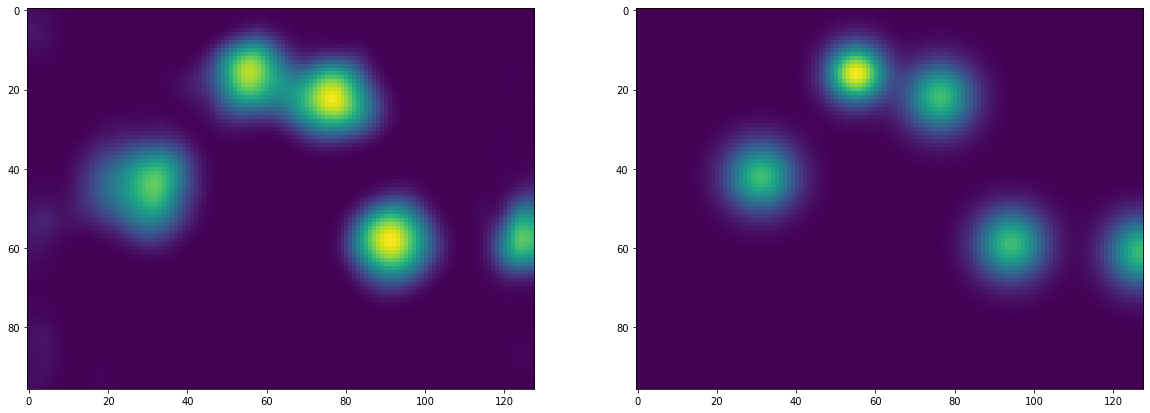

In [ ]:
e=80
ex_val=ndimage.filters.gaussian_filter(model.predict(x_patch[e:e+1]),2)
plt.figure()
f, axarr = plt.subplots(1,2,figsize=(20, 20)) 
axarr[0].imshow(ex_val[0,:,:,0])
axarr[1].imshow(y_patch[e,:,:,0])
print('Predicted Number of people: %4.2f' %(np.sum(ex_val)/1000))
print('Exact Number of people: %4.2f' %(np.sum(y_patch[e])/1000))


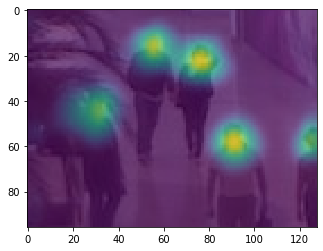

In [ ]:
plt.imshow(x_patch[e,:,:,:])
plt.imshow(ex_val[0,:,:,0],alpha=0.7)

### Prediction for full image
Variable `e` is the index of the data in the array of image patches\
The result of the prediction is saved on variable `ex_val`

Predicted Number of people: 31.86
Exact Number of people: 34.00


<Figure size 432x288 with 0 Axes>

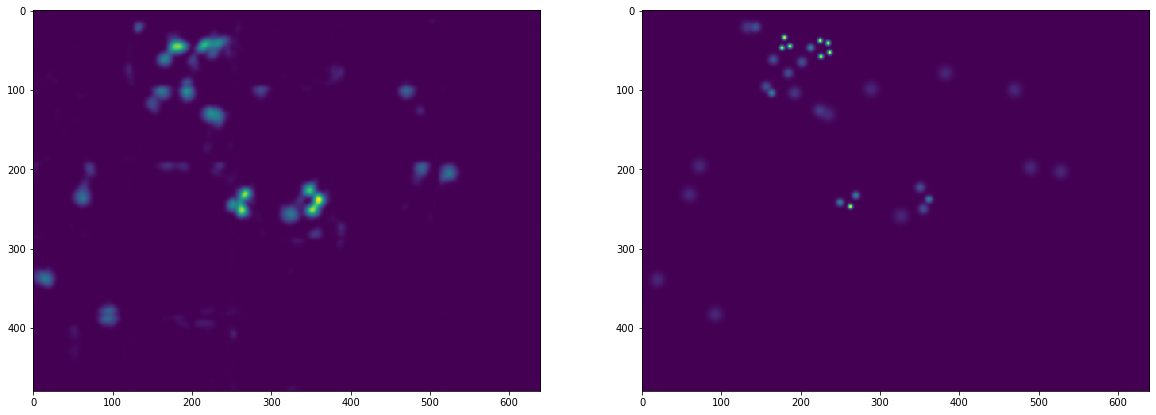

In [ ]:
e=0
ex_val=full_eval(X_val[e:e+1],smooth=True)
plt.figure()
f, axarr = plt.subplots(1,2,figsize=(20, 20)) 
axarr[0].imshow(ex_val)
axarr[1].imshow(Y_val[e,:,:,0])
print('Predicted Number of people: %4.2f' %(np.sum(ex_val)/1000))
print('Exact Number of people: %4.2f' %(np.sum(Y_val[e])/1000))


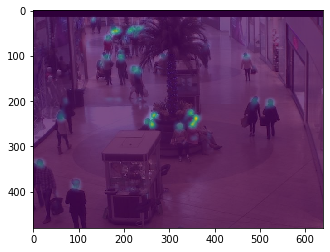

In [ ]:
plt.imshow(X_val[e,:,:,:])
plt.imshow(ex_val,alpha=0.7)

### Model Evaluation on Validation set for full images
The evaluation is done by calculating the Mean Absolute Error (MAE) for the full images on validation set

In [ ]:
full_patch=np.zeros([X_val.shape[0],2])

In [ ]:
error=0
for i in tqdm(range(X_val.shape[0])):
    full_patch[i,0]=np.sum(Y_val[i:i+1])/1000
    full_patch[i,1]=(np.sum(full_eval(X_val[i:i+1],smooth=False)))/1000
    error+=np.abs(full_patch[i,0]-full_patch[i,1])
print('Mean Absolute Error for the Full-Images: %4.2f' %(error/X_val.shape[0]))

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [08:06<00:00,  1.62s/it]

Mean Absolute Error for the Full-Images: 2.17


Text(0.5, 1.0, 'Comparison for Full Images')

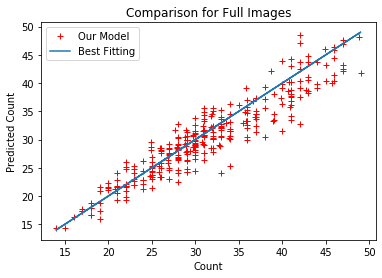

In [ ]:
plt.plot(full_patch[:,0],full_patch[:,1],'r+')
plt.plot(full_patch[:,0],full_patch[:,0])
plt.xlabel('Count')
plt.ylabel('Predicted Count')
plt.legend(['Our Model','Best Fitting'])
plt.title('Comparison for Full Images')

### Model Evaluation on Validation set per image patches
The evaluation is done by calculating the Mean Absolute Error (MAE) for the image patches on validation set

In [ ]:
eval_patch=np.zeros([x_patch.shape[0],2])

In [ ]:
error_patch=0
for i in tqdm(range(x_patch.shape[0])):
    eval_patch[i,0]=np.sum(y_patch[i:i+1])/1000
    eval_patch[i,1]=np.sum(model.predict(x_patch[i:i+1]))/1000
    error_patch+=np.abs((eval_patch[i,0]-eval_patch[i,1]))
print('Mean Absolute Error for the Random Patches in Images: %4.2f' %(error_patch/x_patch.shape[0]))

100%|████████████████████████████████████████████████████████████████████████████████| 900/900 [00:55<00:00, 16.28it/s]

Mean Absolute Error for the Random Patches in Images: 0.47


Text(0.5, 1.0, 'Comparison for Random Patches in Images')

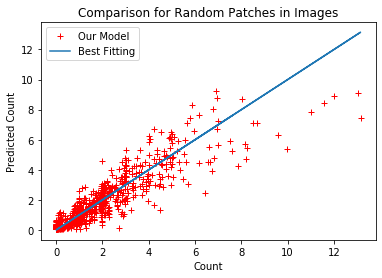

In [ ]:
plt.plot(eval_patch[:,0],eval_patch[:,1],'r+')
plt.plot(eval_patch[:,0],eval_patch[:,0])
plt.xlabel('Count')
plt.ylabel('Predicted Count')
plt.legend(['Our Model','Best Fitting'])
plt.title('Comparison for Random Patches in Images')

In [ ]:
'''model.save_weights("Crowd-CNN")'''